In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sumolib
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule

In [3]:

# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large'
incident_data_module = IncidentDataModule(folder_path = folder_path, transform='standardize', batch_size = 100, spatial_test=True)
incident_data_module.setup()
train_dataloader = incident_data_module.train_dataloader()
train_dataset = train_dataloader.dataset
val_dataloader = incident_data_module.val_dataloader()
val_dataset = val_dataloader.dataset
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

*** DATA SUMMARY: ***
input_obs_full.shape=torch.Size([10270, 147, 6, 10, 3])
input_time_full.shape=torch.Size([10270, 147, 6, 10, 2])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



# HA Baseline v1
* The idea is to find the historical incident that have
* * The same incident edge
* * The same number of blocked lanes
* * The time as close as possible with above constraints
* I checked we have at least 3 candidates for each incident in the val set luckily
* I'll return zero if no match exists

In [4]:
from models.baselines.ha_models import HA_model_v1
from torch import nn
from torchmetrics import MeanAbsolutePercentageError, Accuracy
from torchmetrics.classification import BinaryF1Score
from torchmetrics.functional import precision_recall
from util_folder.ml_utils.result_utils.metric_utils import masked_mape, MetricObj, generate_masks

In [5]:
cur_ie_idx = val_dataset.incident_info[1,0]
cur_n_lanes = val_dataset.incident_info[1,1]
hist_incident_info = train_dataset.incident_info[:]
hist_net_info = train_dataset.network_info[:, :,0]

edge_cost = hist_net_info[:,cur_ie_idx.int()].abs()
lane_cost = (hist_incident_info[:,1] - cur_n_lanes).abs()
combined_cost = edge_cost + lane_cost
min_cost = combined_cost.min()
combined_mask = combined_cost == min_cost
matching_idxs = combined_mask.argwhere()

metric_obj = MetricObj(bce_pos_weight=25.5191)

In [6]:
train_dataset.target_data.shape

torch.Size([5455, 147, 4])

In [7]:
ha_model = HA_model_v1(train_dataset, emulated_dataset_size=5455)
ha_preds = ha_model.predict_dataset(cur_infos=test_dataset.incident_info,
                         cur_input_data=None,
                         cur_input_data_time=test_dataset.input_time_data)
full_test_res = metric_obj.calc_metrics(y_hat=ha_preds,
                                        y_true=test_dataset.target_data,
                                        sigmoid_in_class=False
                                        )
full_test_res['class']

{'bce': tensor(1.0589),
 'acc': tensor(0.9795),
 'f1': tensor(0.7297),
 'prcsn': tensor(0.7103),
 'rcll': tensor(0.7502)}

In [8]:
ha_model = HA_model_v1(train_dataset, emulated_dataset_size=5455)
ha_preds = ha_model.predict_dataset(cur_infos=test_dataset.incident_info,
                         cur_input_data=None,
                         cur_input_data_time=test_dataset.input_time_data)
full_test_res = metric_obj.calc_metrics(y_hat=ha_preds,
                                        y_true=test_dataset.target_data,
                                        sigmoid_in_class=False
                                        )
full_test_res

{'class': {'bce': tensor(1.0589),
  'acc': tensor(0.9795),
  'f1': tensor(0.7297),
  'prcsn': tensor(0.7103),
  'rcll': tensor(0.7502)},
 'start': {'mse': tensor(42.0988),
  'mae': tensor(0.6873),
  'mape': tensor(237961.4844),
  'Mmape': tensor(0.4461)},
 'end': {'mse': tensor(149.6459),
  'mae': tensor(1.7504),
  'mape': tensor(586174.4375),
  'Mmape': tensor(0.4346)},
 'speed': {'mse': tensor(11.1805),
  'mae': tensor(0.4944),
  'mape': tensor(211245.5312),
  'Mmape': tensor(0.3097)}}

In [9]:
test_edge_idxs = torch.tensor([80, 81, 79, 53, 59, 64, 128, 15, 14, 100, 102, 101, 82, 83, 84, 85]) 

# generate masks for subbsets
upstream_mask, multilane_mask, highway_mask, spreading_mask, affected_mask  = generate_masks(test_dataset)
spatial_mask = sum(test_dataset.incident_info[...,0]==idx for idx in test_edge_idxs).bool().unsqueeze(-1).repeat(1, 147)

In [10]:
test_edge_idxs = torch.tensor([80, 81, 79, 53, 59, 64, 128, 15, 14, 100, 102, 101, 82, 83, 84, 85]) 

# generate masks for subbsets
upstream_mask, multilane_mask, highway_mask, spreading_mask, affected_mask  = generate_masks(test_dataset)
spatial_mask = sum(test_dataset.incident_info[...,0]==idx for idx in test_edge_idxs).bool().unsqueeze(-1).repeat(1, 147)

spatial_test_res = metric_obj.calc_metrics(y_hat=ha_preds,
                                           y_true=test_dataset.target_data,
                                           mask=spatial_mask,
                                           sigmoid_in_class=False
                                           )

spatial_test_res

{'class': {'bce': tensor(1.1015),
  'acc': tensor(0.9674),
  'f1': tensor(0.5768),
  'prcsn': tensor(0.5412),
  'rcll': tensor(0.6173)},
 'start': {'mse': tensor(39.6748),
  'mae': tensor(0.8456),
  'mape': tensor(337328.9688),
  'Mmape': tensor(0.5813)},
 'end': {'mse': tensor(166.6429),
  'mae': tensor(2.2496),
  'mape': tensor(893624.5625),
  'Mmape': tensor(0.5547)},
 'speed': {'mse': tensor(18.5602),
  'mae': tensor(0.7761),
  'mape': tensor(362418.4688),
  'Mmape': tensor(0.4357)}}

In [11]:
n_hop_dfs = {}
for hop in range(11):
    n_hop_mask = (test_dataset.network_info[:,:,0] == -hop)
    n_hop_dfs[hop] = metric_obj.calc_metrics(y_hat=ha_preds,
                                            y_true=test_dataset.target_data,
                                            mask=n_hop_mask,
                                            sigmoid_in_class=False
                                            )

In [12]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1:.02f}\t',
          f'{acc:.02f}\t',
          f'{prcsn:.02f}\t',
          f'{rcll:.02f}\t',
          f'{start_mae:.02f}\t',
          f'{end_mae:.02f}\t',
          f'{speed_mae:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.78	 0.68	 0.89	 0.70	 4.57	 19.43	 8.52
1:	 0.82	 0.78	 0.88	 0.76	 4.08	 17.10	 5.53
2:	 0.82	 0.82	 0.85	 0.80	 4.25	 15.11	 4.37
3:	 0.81	 0.84	 0.84	 0.79	 4.57	 14.07	 3.92
4:	 0.81	 0.85	 0.82	 0.81	 5.09	 14.01	 3.70
5:	 0.80	 0.86	 0.80	 0.81	 5.43	 13.61	 3.50
6:	 0.80	 0.87	 0.78	 0.81	 5.42	 13.21	 3.24
7:	 0.79	 0.88	 0.78	 0.80	 5.95	 13.10	 3.11
8:	 0.77	 0.88	 0.75	 0.78	 5.61	 12.41	 3.11
9:	 0.74	 0.88	 0.72	 0.76	 6.13	 12.40	 3.05
10:	 0.71	 0.89	 0.70	 0.71	 5.46	 11.46	 2.80


In [13]:
hist_len = train_dataset.incident_info.shape[0]
subset_res_dicts = []
subset_lens = []
for i in np.arange(0.01,1.01,0.01):
    subset_len = np.floor(hist_len * i).astype(int)

    ha_model = HA_model_v1(train_dataset, emulated_dataset_size=subset_len)
    ha_preds = ha_model.predict_dataset(cur_infos=test_dataset.incident_info,
                            cur_input_data=None,
                            cur_input_data_time=test_dataset.input_time_data)
    subset_res = metric_obj.calc_metrics(y_hat=ha_preds,
                            y_true=test_dataset.target_data,
                            sigmoid_in_class=False
                            )
    
    subset_lens.append(subset_len)
    subset_res_dicts.append(subset_res)

In [14]:
acc_scores = [res['class']['acc'] for res in subset_res_dicts]
f1_scores = [res['class']['f1'] for res in subset_res_dicts]
prec_scores = [res['class']['prcsn'] for res in subset_res_dicts]
rec_scores = [res['class']['rcll'] for res in subset_res_dicts]

[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

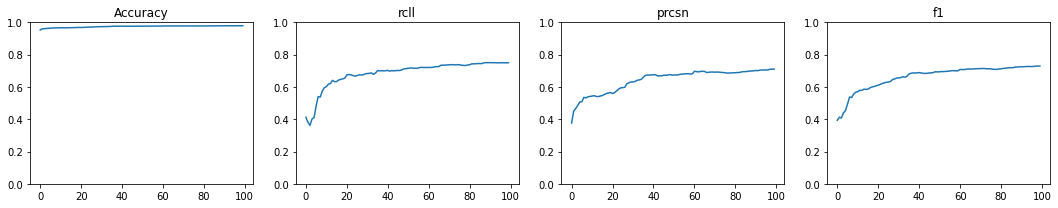

In [15]:
fig, axs = plt.subplots(1,4, figsize=(15,3))
axs[0].plot(acc_scores)
axs[0].set_title('Accuracy')
axs[1].plot(rec_scores)
axs[1].set_title('rcll')
axs[2].plot(prec_scores)
axs[2].set_title('prcsn')
axs[3].plot(f1_scores)
axs[3].set_title('f1')
fig.tight_layout()
[ax.set_ylim(0,1) for ax in axs]

# Diferent dataset size test

In [16]:
incident_data_module = IncidentDataModule(folder_path = folder_path,
                                          transform='standardize',
                                          batch_size = 100,
                                          spatial_test=False,
                                          subset_size=100,                                          
                                          )

incident_data_module.setup()
train_dataloader = incident_data_module.train_dataloader()
train_dataset = train_dataloader.dataset
val_dataloader = incident_data_module.val_dataloader()
val_dataset = val_dataloader.dataset
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

*** DATA SUMMARY: ***
input_obs_full.shape=torch.Size([100, 147, 6, 10, 3])
input_time_full.shape=torch.Size([100, 147, 6, 10, 2])
target_full.shape=torch.Size([100, 147, 4])
incident_info_full.shape=torch.Size([100, 4])
network_info_full.shape=torch.Size([100, 147, 13])

